<a href="https://colab.research.google.com/github/comparativechrono/computational_biology_notebooks/blob/main/linear_vs_mixed_models_worked_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Course:` **Mathematical & Computational Biology**  
`Module:` Linear Models vs. Linear Mixed‑Effects Models  
`Author:` Tim Hearn  
`License:` CC-BY-4.0


## 1 Plain linear model (fixed effects)
$$
y_i = \beta_0 + \beta_1 x_{1i} + \dots + \beta_p x_{pi} + \varepsilon_i,
\qquad \varepsilon_i \sim \text{i.i.d. } N(0, \sigma^2)
$$


* **One set of coefficients** \$\beta$
the same slope and intercept apply to every observation in the data.
* **Independence** once covariates are accounted for, the remaining errors are assumed independent and identically distributed.  
* **Estimation**: ordinary least squares (OLS) or, for generalized linear models, maximum likelihood provides unbiased point estimates and familiar R2.
* Data come from a single “population” and there is no meaningful grouping structure that induces correlation (e.g., one measurement per subject, or subjects chosen truly at random).

---

## 2 Linear *mixed-effects* model
$$
y_{ij} =
\underbrace{\beta_0 + \beta_1 x_{1ij} + \dots}_{\text{fixed effects}}
+ \underbrace{b_{0i} + b_{1i} x_{1ij} + \dots}_{\text{random effects}}
+ \varepsilon_{ij}
$$


$$
b_i \sim N(0, \Psi), \quad \varepsilon_{ij} \sim N(0, \sigma^2)
$$


* **Fixed effects**: still describe the average relationship across the whole dataset.
* **Random effects**: let the intercept, slopes—or both—vary by group (subjects, classrooms, sites, litters, etc.).
*Mathematically they add another layer of normally-distributed variation, so observations within the same group are correlated.*
* The model expects repeated or nested measurements to be related and estimates a covariance structure instead of forcing independence.
* Usually (restricted) maximum likelihood—REML or ML—because both β and the variance–covariance components (Ψ, σ²) must be estimated simultaneously
* Outputs you get:

     * fixed-effect estimates + standard errors (like a regular LM),

     * estimates of between-group variance (random intercept SD, random slope SD, their correlation),

     * “conditional” predictions for each group that shrink toward the population mean (partial pooling).

---

## 3 When to choose which?

| Scenario                                                                 | Plain LM  | LMM               |
| ------------------------------------------------------------------------ | --------- | ----------------- |
| Independent cross-sectional data                                         | ✓         | –                 |
| Repeated measures on the same subject                                    | –         | ✓                 |
| Students nested in schools (or plots in blocks, etc.)                    | –         | ✓                 |
| Interest is *only* in average treatment effect, not individual variation | ✓ (often) | –                 |
| Need to partition variance (within vs. between groups)                   | –         | ✓                 |
| Unequal numbers of observations per group, missing waves                 | awkward   | handled naturally |


> **If rows “belong” together, use a mixed model.**

*(Repeated lines per patient, per school, per factory batch—anything that breaks independence.)*

* Generalization:

     * LMs generalize to new observations within the same population.

     * LMMs, by treating groups as sampled from a broader population, can also generalize to new groups.

---

## 4  Worked example below
We simulate repeated‑measures data, then fit:

1. An OLS model that ignores grouping  
2. A mixed model with random intercepts & slopes

and compare the two.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM

# notebook settings
plt.rcParams['figure.figsize'] = (7,4)


In [2]:
np.random.seed(42)

n_subjects = 20
n_obs = 10  # per subject
subjects = np.repeat(np.arange(n_subjects), n_obs)
time = np.tile(np.arange(n_obs), n_subjects)

# true population parameters
beta_0, beta_1 = 2.0, 0.5
sigma = 1.0            # residual SD
sd_intercept = 1.0     # SD of random intercepts
sd_slope = 0.3         # SD of random slopes
corr = 0.4             # correlation between intercept & slope

# random effects covariance
cov = np.array([[sd_intercept**2, corr*sd_intercept*sd_slope],
                [corr*sd_intercept*sd_slope, sd_slope**2]])

random_effects = np.random.multivariate_normal([0,0], cov, n_subjects)
b0 = random_effects[:,0][subjects]
b1 = random_effects[:,1][subjects]

# generate response
y = (beta_0 + b0) + (beta_1 + b1) * time + np.random.normal(0, sigma, size=len(time))

dat = pd.DataFrame({'y': y,
                    'time': time,
                    'subject': subjects})
dat.head()


,y,time,subject
0,2.246909,0,0
1,2.078039,1,0
2,2.189252,2,0
3,2.402025,3,0
4,1.622836,4,0


In [3]:
model_lm = smf.ols('y ~ time', data=dat).fit()
print(model_lm.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     67.39
Date:                Tue, 11 Nov 2025   Prob (F-statistic):           2.82e-14
Time:                        11:41:04   Log-Likelihood:                -448.03
No. Observations:                 200   AIC:                             900.1
Df Residuals:                     198   BIC:                             906.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1829      0.300      7.270      0.0

In [4]:
model_lmm = smf.mixedlm('y ~ time', data=dat,
                        groups='subject',
                        re_formula='~ time').fit(reml=True)
print(model_lmm.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  y        
No. Observations:    200      Method:              REML     
No. Groups:          20       Scale:               0.9425   
Min. group size:     10       Log-Likelihood:      -331.1047
Max. group size:     10       Converged:           No       
Mean group size:     10.0                                   
------------------------------------------------------------
                   Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          2.183    0.142 15.390 0.000  1.905  2.461
time               0.462    0.158  2.923 0.003  0.152  0.771
subject Var        0.077    0.107                           
subject x time Cov 0.042    0.116                           
time Var           0.488                                    



/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 20.803016
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


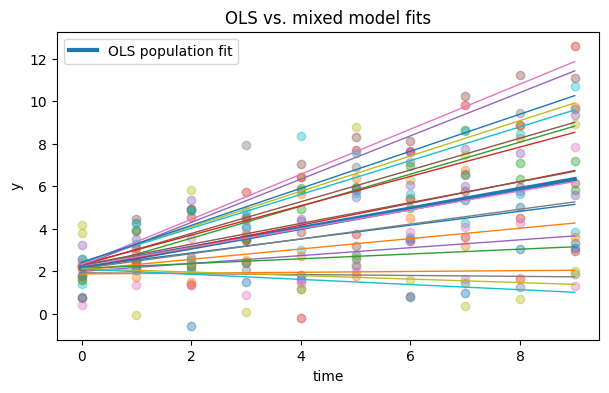

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM

# notebook settings
plt.rcParams['figure.figsize'] = (7,4)

# Visualise each subject's data with fitted lines
fig, ax = plt.subplots()

# plot observed points
for s in dat['subject'].unique():
    sub = dat[dat['subject'] == s]
    ax.plot(sub['time'], sub['y'], marker='o', linestyle='', alpha=0.4)

# population OLS fit line
x_vals = np.linspace(0, n_obs-1, 100)
ax.plot(x_vals,
        model_lm.params['Intercept'] + model_lm.params['time']*x_vals,
        linewidth=3, label='OLS population fit')

# conditional mixed model fits per subject
fe_int = model_lmm.fe_params['Intercept']
fe_slope = model_lmm.fe_params['time']
ran = model_lmm.random_effects
for s, row in ran.items():
    ax.plot(x_vals,
            (fe_int + row['subject']) + (fe_slope + row['time'])*x_vals,
            linewidth=1)

ax.set_xlabel('time')
ax.set_ylabel('y')
ax.set_title('OLS vs. mixed model fits')
ax.legend()
plt.show()


### Interpretation

* **OLS** estimates a single slope/intercept; standard errors are too small because it treats the 200 observations as independent.
* **Mixed model** recognises clustering:
  * Estimates the *population* slope \(\beta_1\) near the truth (0.5).
  * Estimates variance components (SDs of random intercepts/slopes and their correlation).
  * Provides **subject‑specific** lines that *shrink* toward the population average.

The plot illustrates:
* Grey dots = raw data per subject  
* Thin lines = each subject's fitted line from the mixed model  
* Thick line = population‑level OLS fit

Notice how the mixed model lets each subject deviate while borrowing strength from the whole dataset.
